# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В распоряжении есть исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Цель проекта**: создать модель, которая сможет качественно и быстро определить стоимость автомобиля по различным признакам.  

Для оценки качества моделей будет применятся метрика RMSE, ее значение должно быть меньше 2500.

Описание признаков:
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя  

Целевой признак:
* Price — цена (евро)

## Подготовка данных

In [1]:
pip install --upgrade scikit-learn 

Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
warnings.filterwarnings('ignore')
from time import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

from lightgbm import LGBMRegressor

In [3]:
autos_df = pd.read_csv('/datasets/autos.csv')

In [4]:
autos_df.info()
autos_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
autos_df.isna().mean().round(3)*100 # % пропущенных значений по столбцам

DateCrawled           0.0
Price                 0.0
VehicleType          10.6
RegistrationYear      0.0
Gearbox               5.6
Power                 0.0
Model                 5.6
Kilometer             0.0
RegistrationMonth     0.0
FuelType              9.3
Brand                 0.0
Repaired             20.1
DateCreated           0.0
NumberOfPictures      0.0
PostalCode            0.0
LastSeen              0.0
dtype: float64

В 5 столбцах есть пропущенные значения. Посмотрим какие значения есть в этих столбцах

In [6]:
cols_nan = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired']
for col in cols_nan:
    print(f'Unique values {col}: {autos_df[col].unique()} \n')

Unique values VehicleType: [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other'] 

Unique values Gearbox: ['manual' 'auto' nan] 

Unique values Model: ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetl

В связи с тем что все столбцы содержащие пропуски типа 'object', а также чтобы не терять и не искажать данные, заменим все пропущенные значения на 'unknown'

In [7]:
autos_df = autos_df.fillna('unknown')
autos_df.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

Также были замечены неявные дубликаты, а именно, в столбце Model rangerover и range_rover, в столбце FuelType значения petrol и gasoline обозначают одно и тоже - бензин. Исправим это

In [8]:
autos_df['Model'] = autos_df['Model'].replace('rangerover', 'range_rover')
autos_df['FuelType'] = autos_df['FuelType'].replace('gasoline', 'petrol')

In [9]:
sorted(autos_df['Model'].unique())

['100',
 '145',
 '147',
 '156',
 '159',
 '1_reihe',
 '1er',
 '200',
 '2_reihe',
 '300c',
 '3_reihe',
 '3er',
 '4_reihe',
 '500',
 '5_reihe',
 '5er',
 '601',
 '6_reihe',
 '6er',
 '7er',
 '80',
 '850',
 '90',
 '900',
 '9000',
 '911',
 'a1',
 'a2',
 'a3',
 'a4',
 'a5',
 'a6',
 'a8',
 'a_klasse',
 'accord',
 'agila',
 'alhambra',
 'almera',
 'altea',
 'amarok',
 'antara',
 'arosa',
 'astra',
 'auris',
 'avensis',
 'aveo',
 'aygo',
 'b_klasse',
 'b_max',
 'beetle',
 'berlingo',
 'bora',
 'boxster',
 'bravo',
 'c1',
 'c2',
 'c3',
 'c4',
 'c5',
 'c_klasse',
 'c_max',
 'c_reihe',
 'caddy',
 'calibra',
 'captiva',
 'carisma',
 'carnival',
 'cayenne',
 'cc',
 'ceed',
 'charade',
 'cherokee',
 'citigo',
 'civic',
 'cl',
 'clio',
 'clk',
 'clubman',
 'colt',
 'combo',
 'cooper',
 'cordoba',
 'corolla',
 'corsa',
 'cr_reihe',
 'croma',
 'crossfire',
 'cuore',
 'cx_reihe',
 'defender',
 'delta',
 'discovery',
 'doblo',
 'ducato',
 'duster',
 'e_klasse',
 'elefantino',
 'eos',
 'escort',
 'espace',
 

In [10]:
autos_df['FuelType'].unique()

array(['petrol', 'unknown', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

Далее удалим заведомо неинформативные столбцы для модели, такие как DateCrawled, RegistrationMonth, DateCreated, NumberOfPictures, PostalCode, LastSeen. Перед этим проверим данные на явные дубликаты и удалим их.

In [11]:
autos_df.duplicated().sum()

4

In [12]:
autos_df = autos_df.drop_duplicates()

In [13]:
autos_df = autos_df.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

In [14]:
autos_df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,petrol,audi,yes
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no


Далее проверим уникальные значения столбца Brand

In [15]:
sorted(autos_df['Brand'].unique())

['alfa_romeo',
 'audi',
 'bmw',
 'chevrolet',
 'chrysler',
 'citroen',
 'dacia',
 'daewoo',
 'daihatsu',
 'fiat',
 'ford',
 'honda',
 'hyundai',
 'jaguar',
 'jeep',
 'kia',
 'lada',
 'lancia',
 'land_rover',
 'mazda',
 'mercedes_benz',
 'mini',
 'mitsubishi',
 'nissan',
 'opel',
 'peugeot',
 'porsche',
 'renault',
 'rover',
 'saab',
 'seat',
 'skoda',
 'smart',
 'sonstige_autos',
 'subaru',
 'suzuki',
 'toyota',
 'trabant',
 'volkswagen',
 'volvo']

Переходим к количественным признакам

**1. RegistrationYear**

In [16]:
autos_df['RegistrationYear'].describe()

count    354365.000000
mean       2004.234481
std          90.228466
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

In [17]:
sorted(autos_df['RegistrationYear'].unique())

[1000,
 1001,
 1039,
 1111,
 1200,
 1234,
 1253,
 1255,
 1300,
 1400,
 1500,
 1600,
 1602,
 1688,
 1800,
 1910,
 1915,
 1919,
 1920,
 1923,
 1925,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2066,
 2200,
 2222,
 2290,
 2500,
 2800,
 2900,
 3000,
 3200,
 3500,
 3700,
 3800,
 4000,
 4100,
 4500,
 4800,
 5000,
 5300,
 5555,
 5600,
 5900,
 5911,
 6000,
 6500,
 7000,
 7100,
 7500,
 7800,
 8000,
 8200,

Для начала ограничим год регистрации автомобиля с 1909 по 2016 (год выгрузки анкеты из базы), остальные значения это явные аномалии

In [18]:
autos_df = autos_df.query('1909 < RegistrationYear < 2017')

In [19]:
autos_df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,petrol,audi,yes
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no


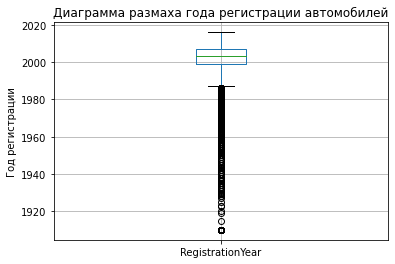

In [20]:
autos_df.boxplot('RegistrationYear')
plt.title('Диаграмма размаха года регистрации автомобилей')
plt.ylabel('Год регистрации')
plt.show()

На диаграмме размаха видим множество выбросов до 1980 года. Рассмотрим более детально этот период.

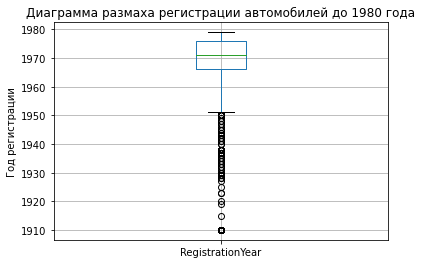

In [21]:
autos_df.query('1909 < RegistrationYear < 1980').boxplot('RegistrationYear')
plt.title('Диаграмма размаха регистрации автомобилей до 1980 года')
plt.ylabel('Год регистрации')
plt.show()

Субъективно, для обучения модели оставляем все автомобили с регистрацией после 1950 года

In [22]:
autos_df = autos_df.query('RegistrationYear > 1950')

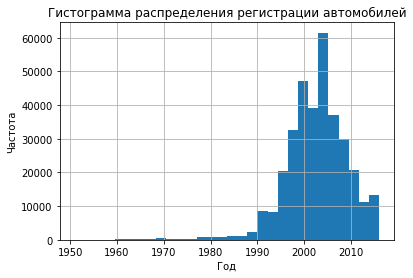

In [23]:
autos_df['RegistrationYear'].hist(bins=30)
plt.title('Гистограмма распределения регистрации автомобилей')
plt.xlabel('Год')
plt.ylabel('Частота')
plt.show()

**2. Power**

In [24]:
autos_df['Power'].describe()

count    339571.000000
mean        111.049398
std         186.904549
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

Сперва удалим явные аномалии - мощность автомобиля более 2030 л.с.

In [25]:
autos_df = autos_df.query('Power < 2030')

Рассмотрим подробнее автомобили с мощностью больше 600 л.с.

In [26]:
autos_df.query('Power > 600')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1816,3200,small,2004,manual,1398,corolla,5000,petrol,toyota,no
2102,0,sedan,1999,unknown,1799,vectra,150000,petrol,opel,yes
4060,3100,sedan,2005,manual,953,colt,150000,petrol,mitsubishi,no
5328,500,wagon,1999,manual,1001,astra,150000,petrol,opel,unknown
6296,599,small,2002,manual,603,matiz,5000,petrol,chevrolet,yes
...,...,...,...,...,...,...,...,...,...,...
348883,7500,sedan,2011,manual,1548,scenic,90000,petrol,renault,unknown
348968,250,small,1999,manual,1241,ypsilon,150000,petrol,lancia,yes
351947,1500,bus,2001,manual,1001,zafira,5000,petrol,opel,no
353633,2400,sedan,2007,manual,650,c2,150000,petrol,citroen,unknown


Тут, вероятно, есть несоответствия по параметру л.с. и марки автомобиля, и так как строк всего 266 - их можно убрать

In [27]:
autos_df = autos_df.query('Power < 601')

Далее заменим все значения мощности менее 10 л.с. на медиану, так как, вероятно, это тоже ошибка

In [28]:
median_power = autos_df['Power'].median()
autos_df.loc[autos_df['Power'] < 10, 'Power'] = median_power

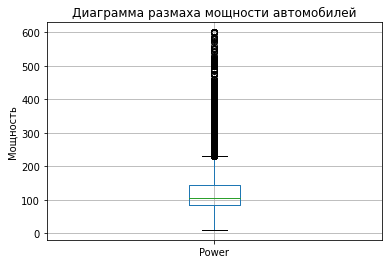

In [29]:
autos_df.boxplot('Power')
plt.title('Диаграмма размаха мощности автомобилей')
plt.ylabel('Мощность')
plt.show()

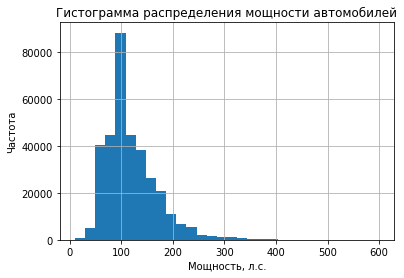

In [30]:
autos_df['Power'].hist(bins=30)
plt.title('Гистограмма распределения мощности автомобилей')
plt.xlabel('Мощность, л.с.')
plt.ylabel('Частота')
plt.show()

**3. Kilometer**

In [31]:
autos_df['Kilometer'].describe()

count    339223.000000
mean     128132.452693
std       37827.149085
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

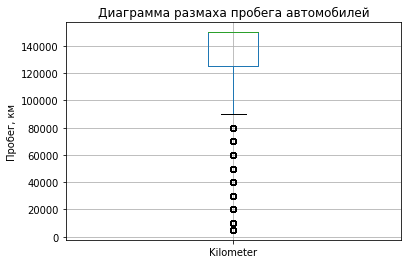

In [32]:
autos_df.boxplot('Kilometer')
plt.title('Диаграмма размаха пробега автомобилей')
plt.ylabel('Пробег, км')
plt.show()

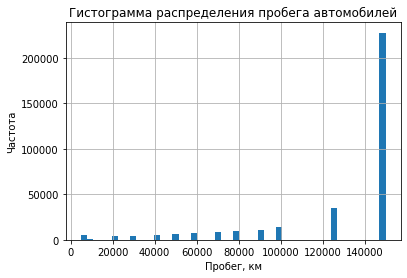

In [33]:
autos_df['Kilometer'].hist(bins=50)
plt.title('Гистограмма распределения пробега автомобилей')
plt.xlabel('Пробег, км')
plt.ylabel('Частота')
plt.show()

Здесь видим, что максимальное значение пробега равно медианному, что выглядит странно. Скорее всего, у многих автомобилей пробег далеко за 150 тыс. км ушел, но по каким-то причинам выше этого значения пробеги не ставились.

**4. Целевой признак Price**

In [34]:
autos_df['Price'].describe()

count    339223.000000
mean       4472.974781
std        4545.769580
min           0.000000
25%        1100.000000
50%        2799.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

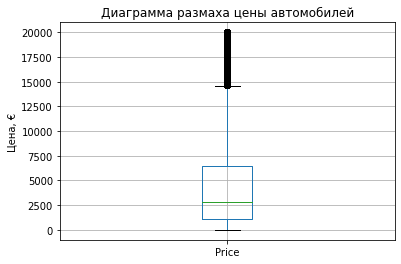

In [35]:
autos_df.boxplot('Price')
plt.title('Диаграмма размаха цены автомобилей')
plt.ylabel('Цена, €')
plt.show()

Здесь аномалии убирать не следует, а вот нулевые и околонулевые значения вероятнее всего ошибки. Уберем строки с ценой продажи менее 100 евро

In [36]:
autos_df = autos_df.query('Price > 100')

Уберем снова дубликаты, сбросим индексы и выведем информациию об итоговом датасете

In [37]:
autos_df = autos_df.drop_duplicates()

In [38]:
autos_df = autos_df.reset_index(drop=True)

In [39]:
autos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282895 entries, 0 to 282894
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             282895 non-null  int64  
 1   VehicleType       282895 non-null  object 
 2   RegistrationYear  282895 non-null  int64  
 3   Gearbox           282895 non-null  object 
 4   Power             282895 non-null  float64
 5   Model             282895 non-null  object 
 6   Kilometer         282895 non-null  int64  
 7   FuelType          282895 non-null  object 
 8   Brand             282895 non-null  object 
 9   Repaired          282895 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 21.6+ MB


**Вывод**

На этапе подготовки данных были обработаны пропуски. Исправлены неявные дубликаты. Удалены неиформативные для моделей столбцы (6). Убраны аномальные значения в количественных признаках. В итоге получился датасет с целевым и 9 входными признаками. Общее количество строк сократилось на 71474

## Обучение моделей

### Подготовка данных

Поделим выборку на тренировочную, валидационную и тестовую

In [40]:
RANDOM_STATE = 42

X = autos_df.drop('Price', axis=1)
y = autos_df['Price']

'''
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=RANDOM_STATE)

X_valid, X_test, y_valid, y_test = train_test_split(
    X,
    y,
    test_size=0.5,
    random_state=RANDOM_STATE)
'''

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=RANDOM_STATE)

Создадим списки со столбцами для обработки признаков перед обучением и общий пайплайн для подготовки данных

In [43]:
ohe_cols = ['Gearbox', 'Repaired', 'VehicleType', 'Model', 'FuelType', 'Brand']
num_cols = ['RegistrationYear', 'Power', 'Kilometer']

In [44]:
scaler = StandardScaler()
ohe_encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_encoder, ohe_cols),
        ('num', scaler, num_cols)
    ],
    remainder='passthrough')

### LinearRegression

In [45]:
linear = LinearRegression()
linear_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('linear', linear)])

start = time()

linear_pipe.fit(X_train, y_train)

end = time()

linear_fit_time = (end-start)
print(f'Время обучения LinearRegression: {linear_fit_time} c')

Время обучения LinearRegression: 21.05100393295288 c


In [46]:
start = time()

y_pred_linear = linear_pipe.predict(X_train)

end = time()

linear_pred_time = (end-start)
print(f'Время предсказания LinearRegression: {linear_pred_time} c')

Время предсказания LinearRegression: 1.2036945819854736 c


In [47]:
linear = LinearRegression()

linear_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('linear', linear)])

rmse_linear = -(cross_val_score(linear_pipe, X_train, y_train, scoring='neg_root_mean_squared_error')).mean()

In [48]:
print(f'LinearRegression RMSE: {rmse_linear}')

LinearRegression RMSE: 2730.714980417484


### DecisionTree

Подберем гиперпараметры для модели дерева решений

In [73]:
tree = DecisionTreeRegressor(random_state=RANDOM_STATE)

tree_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('tree', tree)])

param_tree = {
    'tree__max_depth': range(78, 100, 2),
    'tree__max_features': range(2, 8)
}
rnd_tree = RandomizedSearchCV(tree_pipe, param_tree, scoring='neg_root_mean_squared_error', random_state=RANDOM_STATE, n_jobs=-1)
rnd_tree.fit(X_train, y_train)
print(rnd_tree.best_estimator_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gearbox', 'Repaired',
                                                   'VehicleType', 'Model',
                                                   'FuelType', 'Brand']),
                                                 ('num', StandardScaler(),
                                                  ['RegistrationYear', 'Power',
                                                   'Kilometer'])])),
                ('tree',
                 DecisionTreeRegressor(max_depth=92, max_features=5,
                                       random_state=42))

In [74]:
rmse_tree = -rnd_tree.best_score_
print(f'DecisionTreeRegressor RMSE: {rmse_tree}')

DecisionTreeRegressor RMSE: 2304.181274935142


In [76]:
tree_best = DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth=92, max_features=5)
tree_pipe_best = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('tree_best', tree_best)])

start = time()

tree_pipe_best.fit(X_train, y_train)

end = time()
tree_fit_time = (end-start)
print(f'Время обучения DecisionTreeRegressor: {tree_fit_time} c')

Время обучения DecisionTreeRegressor: 2.094743013381958 c


In [77]:
start = time()

y_pred_tree = tree_pipe_best.predict(X_train)

end = time()
tree_pred_time = (end-start)
print(f'Время предсказания DecisionTreeRegressor: {tree_pred_time} c')

Время предсказания DecisionTreeRegressor: 1.293208122253418 c


### LightGBM

Подберем гиперпараметры для модели LightGBM (реализация дерева решений с градиентным бустингом). Этот процесс достаточно долгий, поэтому код был закомментирован после нахождения лучших гиперпараметров при заданных ограничениях.

In [53]:
lgbm = LGBMRegressor(random_state=RANDOM_STATE)

lgbm_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lgbm', lgbm)])

param_lgbm = {
    'lgbm__max_depth': range(5, 10, 2),
    'lgbm__num_leaves': range(26, 35, 2)
}
rnd_lgbm = RandomizedSearchCV(lgbm_pipe, param_lgbm, scoring='neg_root_mean_squared_error', random_state=RANDOM_STATE, n_jobs=-1)
rnd_lgbm.fit(X_train, y_train)
print(rnd_lgbm.best_estimator_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gearbox', 'Repaired',
                                                   'VehicleType', 'Model',
                                                   'FuelType', 'Brand']),
                                                 ('num', StandardScaler(),
                                                  ['RegistrationYear', 'Power',
                                                   'Kilometer'])])),
                ('lgbm',
                 LGBMRegressor(max_depth=9, num_leaves=34, random_state=42))])


In [54]:
rmse_lgbm = -rnd_lgbm.best_score_
print(f'LGBMRegressor RMSE: {rmse_lgbm}')

LGBMRegressor RMSE: 1748.0279580503216


In [55]:
lgbm_best = LGBMRegressor(random_state=RANDOM_STATE, max_depth=9, num_leaves=34)
lgbm_pipe_best = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lgbm_best', lgbm_best)])

start = time()

lgbm_pipe_best.fit(X_train, y_train)

end = time()
lgbm_fit_time = (end-start)
print(f'Время обучения LGBMRegressor: {lgbm_fit_time} c')

Время обучения LGBMRegressor: 7.994292736053467 c


In [56]:
start = time()

y_pred_lgbm = lgbm_pipe_best.predict(X_train)

end = time()
lgbm_pred_time = (end-start)
print(f'Время предсказания LGBMRegressor: {lgbm_pred_time} c')

Время предсказания LGBMRegressor: 3.0928714275360107 c


**Вывод**

На этапе обучения моделей была произведена разбивка данных на тренировочную и тестовую выборки. Построены 3 модели, для двух из них подобраны гиперпараметры. Расчитаны метрики качества каждой из них, а также времена обучения и предсказания.

## Анализ моделей

In [78]:
analysis_table = pd.DataFrame({
    'name': ['LinearRegression', 'DecisionTreeRegressor', 'LGBMRegressor'],
    'rmse': [rmse_linear, rmse_tree, rmse_lgbm],
    'time_fit_s': [linear_fit_time, tree_fit_time, lgbm_fit_time],
    'time_pred_s': [linear_pred_time, tree_pred_time, lgbm_pred_time]
})
analysis_table

,name,rmse,time_fit_s,time_pred_s
0,LinearRegression,2730.714980,21.051004,1.203695
1,DecisionTreeRegressor,2304.181275,2.094743,1.293208
2,LGBMRegressor,1748.027958,7.994293,3.092871


Наилучшей по качеству модели оказалась LGBMRegressor со значением RMSE 1751.6. Время обучения этой модели хуже в 10, чем у LinearRegression. По скорости предсказания эта модель тоже значительно отстает от двух других. DecisionTreeRegressor показала значение RMSE 2046.7, что попадает в критерии заказчика, а скорости ее обучения и предсказания сопоставимы с LinearRegression. Проверим ее на тестовой выборке.

In [79]:
%%time

y_pred = tree_pipe_best.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'DecisionTreeRegressor (test) RMSE: {rmse}')

DecisionTreeRegressor (test) RMSE: 2369.9300241986225
CPU times: user 255 ms, sys: 174 ms, total: 429 ms
Wall time: 428 ms


**Вывод**

На этапе анализа моделей выполнено сравнение моделей по критериям заказчика. Наилучшей по качеству модели оказалась LGBMRegressor со значением RMSE 1751.6. Время обучения этой модели хуже в 10, чем у LinearRegression. По скорости предсказания эта модель тоже значительно отстает от двух других. DecisionTreeRegressor показала значение RMSE 2046.7, что попадает в критерии заказчика, а скорости ее обучения и предсказания сопоставимы с LinearRegression. Посчитаны RMSE на тестовой выборке - 1984.7, что является допустимым по условию

In [58]:
dummy = DummyRegressor()

dummy_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('dummy', dummy)])

dummy_pipe.fit(X_train, y_train)

y_pred_dummy = dummy_pipe.predict(X_test)

rmse_dummy = mean_squared_error(y_test, y_pred_dummy, squared=False)
print(f'DummyRegressor (test) RMSE: {rmse_dummy}')

DummyRegressor (test) RMSE: 4601.366349115148


## Общий вывод

На этапе подготовки данных были обработаны пропуски. Исправлены неявные дубликаты. Удалены неиформативные для моделей столбцы (6). Убраны аномальные значения в количественных признаках. В итоге получился датасет с целевым и 9 входными признаками. Общее количество строк сократилось на 71474.  
На этапе обучения моделей была произведена разбивка данных на тренировочную и тестовую выборки. Построены 3 модели, для двух из них подобраны гиперпараметры. Расчитаны метрики качества каждой из них, а также времена обучения и предсказания.    
На этапе анализа моделей выполнено сравнение моделей по критериям заказчика. Наилучшей по качеству модели оказалась LGBMRegressor со значением RMSE 1751.6. Время обучения этой модели хуже в 10, чем у LinearRegression. По скорости предсказания эта модель тоже значительно отстает от двух других. DecisionTreeRegressor показала значение RMSE 2046.7, что попадает в критерии заказчика, а скорости ее обучения и предсказания сопоставимы с LinearRegression. Посчитаны RMSE на тестовой выборке - 1984.7, что является допустимым по условию.  
Рекомендуемая модель DecisionTreeRegressor(max_depth=14, max_features=5).